In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statannot import add_stat_annotation
from adjustText import adjust_text

anot = pd.read_csv('aneuploidy_data_NEW.csv',index_col=0)

anot_CCLE = anot.copy()
anot_CCLE.index = anot_CCLE.loc[:,'CCLE_ID']

from cds import plotting

my_pal = {"Diploid": "C0", "Aneuploid": "firebrick"}
my_order = order=['Diploid','Aneuploid']

from taigapy import TaigaClient
tc = TaigaClient()

gene_effect_rnai_achilles = tc.get(name='demeter2-achilles-5386', version=13, file='gene_effect')
gene_effect_rnai_drive = tc.get(name='demeter2-drive-0591', version=12, file='gene_effect')
gene_effect_crispr_achilles = tc.get(name='avana-public-tentative-19q4-c2df', version=4, file='gene_effect')



In [2]:
sample_info = tc.get(name='internal-19q4-fb11', version=29, file='sample_info')
sample_info.index = sample_info.loc[:,'CCLE_Name'] 
sample_info = sample_info[~sample_info.index.duplicated(keep='first')]
sample_info_ = sample_info.copy()
sample_info_.index = sample_info_.loc[:,'DepMap_ID']

# get protein data
protein_quant_current_normalized = tc.get(name='total-proteome--5c50', version=1, file='protein_quant_current_normalized')
protein_quant_current_normalized.index = protein_quant_current_normalized.loc[:,'Gene_Symbol']
protein_quant_current_normalized.columns = protein_quant_current_normalized.columns.str.split('_Ten').str[0]
protein_quant_current_normalized = protein_quant_current_normalized.loc[:,'MDAMB468_BREAST':].T
protein_quant_current_normalized = protein_quant_current_normalized[~protein_quant_current_normalized.index.duplicated(keep=False)]

# get mrna data
public_19Q4_proteincoding_tpm = tc.get(name='depmap-rnaseq-expression-data-ccd0', version=16, file='public_19Q4_proteincoding_tpm')
public_19Q4_proteincoding_tpm_ccle =  public_19Q4_proteincoding_tpm.copy()
public_19Q4_proteincoding_tpm_ccle.index = sample_info_.loc[public_19Q4_proteincoding_tpm.index,'CCLE_Name']
public_19Q4_proteincoding_tpm_ccle.columns = public_19Q4_proteincoding_tpm_ccle.columns.str.split(' ').str[0]

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5,1,'(spearman)')

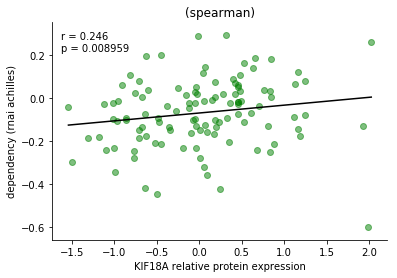

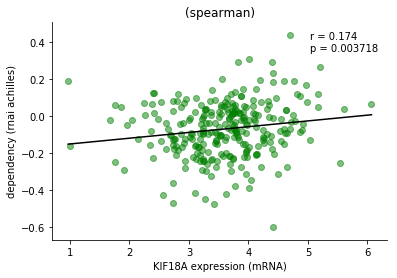

In [3]:
import scipy
from scipy import stats


gene_effect_rnai_achilles.columns = gene_effect_rnai_achilles.columns.str.split(' ').str[0]
gene_effect_rnai_drive.columns = gene_effect_rnai_drive.columns.str.split(' ').str[0]
gene_effect_crispr_achilles.columns = gene_effect_crispr_achilles.columns.str.split(' ').str[0]


shared = set(protein_quant_current_normalized.loc[:,'KIF18A'].dropna().index) & set(gene_effect_rnai_achilles.loc[:,'KIF18A'].dropna().index)


fig,ax= plt.subplots()
plt.scatter(protein_quant_current_normalized.loc[shared,'KIF18A'],gene_effect_rnai_achilles.loc[shared,'KIF18A'],label=None,color='green',alpha=.5)

plt.ylabel('dependency (rnai achilles)')
plt.xlabel('KIF18A relative protein expression')

plotting.simpleaxis()


plt.plot(np.unique(protein_quant_current_normalized.loc[shared,'KIF18A']), np.poly1d(np.polyfit(protein_quant_current_normalized.loc[shared,'KIF18A'], gene_effect_rnai_achilles.loc[shared,'KIF18A'], 1))(np.unique(protein_quant_current_normalized.loc[shared,'KIF18A'])),color='black')

r,p = scipy.stats.spearmanr(gene_effect_rnai_achilles.loc[shared,'KIF18A'],protein_quant_current_normalized.loc[shared,'KIF18A'])
ax.legend(title='r = ' + str(round(r,3)) + '\np = '+ str(round(p,6)),frameon=False)
plt.title('(spearman)')



shared = set(public_19Q4_proteincoding_tpm_ccle.loc[:,'KIF18A'].dropna().index) & set(gene_effect_rnai_achilles.loc[:,'KIF18A'].dropna().index)


fig,ax= plt.subplots()
plt.scatter(public_19Q4_proteincoding_tpm_ccle.loc[shared,'KIF18A'],gene_effect_rnai_achilles.loc[shared,'KIF18A'],label=None,alpha=.5,color='green')

plt.ylabel('dependency (rnai achilles)')
plt.xlabel('KIF18A expression (mRNA)')

plotting.simpleaxis()


plt.plot(np.unique(public_19Q4_proteincoding_tpm_ccle.loc[shared,'KIF18A']), np.poly1d(np.polyfit(public_19Q4_proteincoding_tpm_ccle.loc[shared,'KIF18A'], gene_effect_rnai_achilles.loc[shared,'KIF18A'], 1))(np.unique(public_19Q4_proteincoding_tpm_ccle.loc[shared,'KIF18A'])),color='black')

r,p = scipy.stats.spearmanr(public_19Q4_proteincoding_tpm_ccle.loc[shared,'KIF18A'],gene_effect_rnai_achilles.loc[shared,'KIF18A'])
ax.legend(title='r = ' + str(round(r,3)) + '\np = '+ str(round(p,6)),frameon=False)
plt.title('(spearman)')



/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


p-value for BUB1B: 0.17351640007510927


No handles with labels found to put in legend.


p-value for BUB1B: 0.14482310724707717


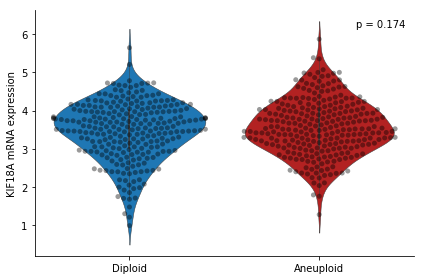

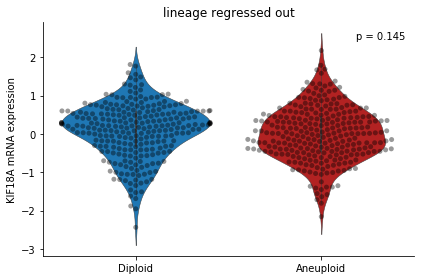

In [4]:
### mrna expression data ###

# want to regress out lineage from the expression data

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder

public_19Q4_proteincoding_tpm.columns = public_19Q4_proteincoding_tpm.columns.str.split(' ').str[0]
public_19Q4_proteincoding_tpm_ = public_19Q4_proteincoding_tpm.loc[:,['KIF18A']]
enc = OneHotEncoder(handle_unknown='ignore')

one_hot = pd.get_dummies(sample_info_.loc[public_19Q4_proteincoding_tpm.index,'lineage'])
mu = public_19Q4_proteincoding_tpm_.mean()
reg = LinearRegression().fit(one_hot, public_19Q4_proteincoding_tpm_)
preds = pd.DataFrame(reg.predict(one_hot),index = public_19Q4_proteincoding_tpm_.index,columns = public_19Q4_proteincoding_tpm_.columns)

preds_ = preds 
corrected_mrna = ((public_19Q4_proteincoding_tpm_  - mu)- preds_)+ mu


########

shared = set(anot.index) & set(public_19Q4_proteincoding_tpm.index)
temp = public_19Q4_proteincoding_tpm.loc[shared]
temp['ploidy'] = anot.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'

sns.violinplot(y = 'KIF18A',x='ploidy', data = temp.loc[:,['KIF18A','ploidy']].dropna(),saturation=1,linewidth=.5,order=my_order,palette = my_pal)
sns.swarmplot(y = 'KIF18A',x='ploidy', data = temp.loc[:,['KIF18A','ploidy']].dropna(),color='black',alpha=.4,order=my_order)


from scipy import stats
tt,p_val = stats.ttest_ind(public_19Q4_proteincoding_tpm.loc[trus,'KIF18A'].dropna(),public_19Q4_proteincoding_tpm.loc[falsee,'KIF18A'].dropna())
print('p-value for BUB1B: ' + str(p_val))
plt.legend(title='p = '+ str(round(p_val,3)),frameon=False)
plotting.simpleaxis()
plt.ylabel('KIF18A mRNA expression')
plt.xlabel('')
plt.tight_layout()

plt.figure()
##########


shared = set(anot.index) & set(corrected_mrna.index)
temp = corrected_mrna.loc[shared]
temp['ploidy'] = anot.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'





sns.violinplot(y = 'KIF18A',x='ploidy', data = temp.loc[:,['KIF18A','ploidy']].dropna(),saturation=1,linewidth=.5,order=my_order,palette = my_pal)
sns.swarmplot(y = 'KIF18A',x='ploidy', data = temp.loc[:,['KIF18A','ploidy']].dropna(),color='black',alpha=.4,order=my_order)


from scipy import stats
tt,p_val = stats.ttest_ind(corrected_mrna.loc[trus,'KIF18A'].dropna(),corrected_mrna.loc[falsee,'KIF18A'].dropna())
print('p-value for BUB1B: ' + str(p_val))
plt.legend(title='p = '+ str(round(p_val,3)),frameon=False)
plotting.simpleaxis()
plt.ylabel('KIF18A mRNA expression')
plt.xlabel('')
plt.title('lineage regressed out')
plt.tight_layout()


/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.


p-value for BUB1B: 0.11927284784738944
p-value for BUB1B: 0.15913991357434384


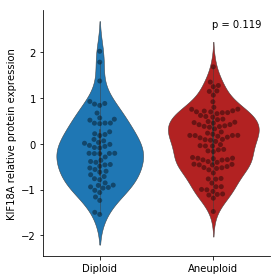

<Figure size 432x288 with 0 Axes>

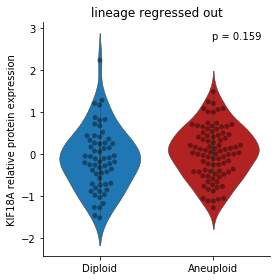

In [5]:
### protein data ###

fig,axx = plt.subplots(figsize=(4,4))


shared = set(anot_CCLE.index) & set(protein_quant_current_normalized.index)
temp = protein_quant_current_normalized.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'


sns.violinplot(y = 'KIF18A',x='ploidy', data = temp.loc[:,['KIF18A','ploidy']].dropna(),saturation=1,linewidth=.5,order=my_order,palette = my_pal)
sns.swarmplot(y = 'KIF18A',x='ploidy', data = temp.loc[:,['KIF18A','ploidy']].dropna(),color='black',alpha=.4,order=my_order)


from scipy import stats
tt,p_val = stats.ttest_ind(protein_quant_current_normalized.loc[trus,'KIF18A'].dropna(),protein_quant_current_normalized.loc[falsee,'KIF18A'].dropna())
print('p-value for BUB1B: ' + str(p_val))
plt.legend(title='p = '+ str(round(p_val,3)),frameon=False)
plotting.simpleaxis()
plt.ylabel('KIF18A relative protein expression')
plt.xlabel('')
plt.tight_layout()

plt.figure()
####


protein_quant_current_normalized_ = protein_quant_current_normalized.loc[:,['KIF18A']].dropna()

# now need to regress out lineage from the relative protein expression data
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

one_hot = pd.get_dummies(sample_info.loc[protein_quant_current_normalized_.index,'lineage'])
mu = protein_quant_current_normalized_.mean()
reg = LinearRegression().fit(one_hot, protein_quant_current_normalized_)
preds = pd.DataFrame(reg.predict(one_hot),index = protein_quant_current_normalized_.index,columns = protein_quant_current_normalized_.columns)

preds_ = preds 
corrected_protein = ((protein_quant_current_normalized_  - mu)- preds_)+ mu






fig,axx = plt.subplots(figsize=(4,4))


shared = set(anot_CCLE.index) & set(corrected_protein.index)
temp = corrected_protein.loc[shared]
temp['ploidy'] = anot_CCLE.loc[temp.index,'many_arm_events']

trus = temp[temp.loc[:,'ploidy']==True].index 
temp.loc[trus,'ploidy']= 'Aneuploid'
falsee = temp[temp.loc[:,'ploidy']==False].index 
temp.loc[falsee,'ploidy']=  'Diploid'





sns.violinplot(y = 'KIF18A',x='ploidy', data = temp.loc[:,['KIF18A','ploidy']].dropna(),saturation=1,linewidth=.5,order=my_order,palette = my_pal)
sns.swarmplot(y = 'KIF18A',x='ploidy', data = temp.loc[:,['KIF18A','ploidy']].dropna(),color='black',alpha=.4,order=my_order)


from scipy import stats
tt,p_val = stats.ttest_ind(corrected_protein.loc[trus,'KIF18A'].dropna(),corrected_protein.loc[falsee,'KIF18A'].dropna())
print('p-value for BUB1B: ' + str(p_val))
plt.legend(title='p = '+ str(round(p_val,3)),frameon=False)
plotting.simpleaxis()
plt.ylabel('KIF18A relative protein expression')
plt.xlabel('')
plt.title('lineage regressed out')
plt.tight_layout()


In [6]:
### make tables ###


#### t tests for each lineage, protein data ###

anot = pd.read_csv('aneuploidy_data_NEW_COMPACT.csv',index_col=0)
anot_CCLE = anot.copy()
anot_CCLE.index = anot_CCLE.loc[:,'CCLE_ID']


table = pd.DataFrame(columns = ['num_lines','num_true','num_false','t-stat','p-value'],index = set(sample_info.loc[anot_CCLE.index,'lineage']))

for lineage in set(sample_info.loc[anot_CCLE.index,'lineage']):
    all_lines = sample_info[sample_info.loc[:,'lineage'] == lineage].index
    all_lines = set(all_lines) & set(anot_CCLE.index) & set(protein_quant_current_normalized.loc[:,'KIF18A'].dropna().index)
    trus = anot_CCLE.loc[all_lines][anot_CCLE.loc[all_lines,'many_arm_events'] == True].index
    fals =  anot_CCLE.loc[all_lines][anot_CCLE.loc[all_lines,'many_arm_events'] == False].index
    tt,p_val = stats.ttest_ind(protein_quant_current_normalized.loc[trus,'KIF18A'].dropna(),protein_quant_current_normalized.loc[fals,'KIF18A'].dropna())
    table.loc[lineage] = [len(all_lines),len(trus),len(fals),tt,p_val]

print('#### t tests for each lineage, protein data ###')
print(table) 

print()
print('#### t tests for each lineage, mRNA data ###')


#### t tests for each lineage, mRNA data ###
table = pd.DataFrame(columns = ['num_lines','num_true','num_false','t-stat','p-value'],index = set(sample_info.loc[anot_CCLE.index,'lineage']))

for lineage in set(sample_info_.loc[anot.index,'lineage']):
    all_lines = sample_info_[sample_info_.loc[:,'lineage'] == lineage].index
    all_lines = set(all_lines) & set(anot.index) & set(public_19Q4_proteincoding_tpm.loc[:,'KIF18A'].dropna().index)
    trus = anot.loc[all_lines][anot.loc[all_lines,'many_arm_events'] == True].index
    fals =  anot.loc[all_lines][anot.loc[all_lines,'many_arm_events'] == False].index
    tt,p_val = stats.ttest_ind(public_19Q4_proteincoding_tpm.loc[trus,'KIF18A'].dropna(),public_19Q4_proteincoding_tpm.loc[fals,'KIF18A'].dropna())
    table.loc[lineage] = [len(all_lines),len(trus),len(fals),tt,p_val]

print(table) 

#### t tests for each lineage, protein data ###
                          num_lines num_true num_false    t-stat     p-value
gastric                           7        4         3   0.18582     0.85989
esophagus                         7        7         0       NaN         NaN
urinary_tract                     2        2         0       NaN         NaN
thyroid                           1        1         0       NaN         NaN
colorectal                       13        5         8  0.462005    0.653081
prostate                          3        2         1       NaN         NaN
upper_aerodigestive               3        3         0       NaN         NaN
peripheral_nervous_system         0        0         0       NaN         NaN
skin                              9        7         2 -0.409777     0.69422
pancreas                          6        6         0       NaN         NaN
ovary                            10        6         4   4.13449  0.00327815
blood                       

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
#### pearson correlation for each lineage, protein data ###

an_full = pd.read_csv('aneuploidy_data_NEW.csv',index_col='DepMap_ID')


print('#### pearson correlation for each lineage, protein data ###')
an_full.index = an_full.loc[:,'CCLE_ID']

table2 = pd.DataFrame(columns = ['num_lines','R','p-value'],index = set(sample_info.loc[anot_CCLE.index,'lineage']))

for lineage in set(sample_info.loc[an_full.loc[:,'CCLE_ID'],'lineage']):
    all_lines = sample_info[sample_info.loc[:,'lineage'] == lineage].index
    all_lines = set(all_lines) & set(an_full.loc[:,'CCLE_ID']) & set(protein_quant_current_normalized.loc[:,'KIF18A'].dropna().index)
    r,p = scipy.stats.pearsonr(an_full.loc[all_lines,'num_arm_events'],protein_quant_current_normalized.loc[all_lines,'KIF18A'])


    table2.loc[lineage] = [len(all_lines),r,p]
    
print(table2)

print('\n#### pearson correlation for each lineage, mrna data ###')
an_full = pd.read_csv('aneuploidy_data_NEW.csv',index_col='DepMap_ID')


table2 = pd.DataFrame(columns = ['num_lines','R','p-value'],index = set(sample_info_.loc[anot.index,'lineage']))

for lineage in set(sample_info_.loc[an_full.index,'lineage']):
    all_lines = sample_info_[sample_info_.loc[:,'lineage'] == lineage].index
    all_lines = set(all_lines) & set(an_full.index) & set(public_19Q4_proteincoding_tpm.loc[:,'KIF18A'].dropna().index)
    r,p = scipy.stats.pearsonr(an_full.loc[all_lines,'num_arm_events'],public_19Q4_proteincoding_tpm.loc[all_lines,'KIF18A'])


    table2.loc[lineage] = [len(all_lines),r,p]
    
print(table2)

#### pearson correlation for each lineage, protein data ###
                          num_lines          R     p-value
gastric                          14   0.115406    0.694418
esophagus                        13   0.245124    0.419561
urinary_tract                     8  -0.276107    0.508009
thyroid                           1        NaN         NaN
colorectal                       25   0.105989    0.614094
prostate                          4   0.664804    0.335196
upper_aerodigestive               8  -0.140421    0.740152
peripheral_nervous_system         1        NaN         NaN
skin                             22  -0.160448    0.475672
pancreas                         17 -0.0477777    0.855512
ovary                            15   0.697007  0.00387895
blood                            17  -0.386012    0.125925
breast                           23 -0.0620327    0.778573
bile_duct                         1        NaN         NaN
plasma_cell                       5   0.461351     0.43

/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3005: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mkazachk/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3006: RuntimeWarning: Mean of empty slice.
  my = y.mean()
